My pytroch adv train is being weird. I'm going to run it in a notebook to see if it makes sense.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import h5py

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
from uatu.scattering import *
from kymatio import Scattering2D

In [5]:
from scipy import fftpack
from scipy.ndimage import gaussian_filter
import numpy as np
import pylab as py
#import radialProfile
from scipy.fftpack import fft2

In [6]:
#mode = 2
mode = 0
#max_order = 2
max_order = 0

#J = 2
J = 0
L = 8
K = int(1 + L*J +(L**2)*(J*(J-1))/2.0)

width = 2
smooth = 0
shape = (256, 256)

In [7]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [8]:
scattering = lambda x: x
#scattering = lambda x: gaussian_filter(x, 1)

In [9]:
model = GuptaNet(1).to(device)

In [10]:
model_path = '/home/sean/Git/uatu/networks/gupta_net_smooth_0_epoch_33.pth'
model.load_state_dict(torch.load(model_path, map_location='cpu'))

<All keys matched successfully>

In [11]:
from uatu.scattering.attack import *

In [12]:
def compute_attacked_map(model, scattering, cost_fn, data, target, use_log_barrier = False, n_steps = 5):#, log_eps = 1.5)

    # Send the data and label to the device
    #data, target = data.to(device), target.to(device)
    # Set requires_grad attribute of tensor. Important for Attack
    perturbed_data = data.clone()
    for i in range(n_steps):

        perturbed_data.requires_grad_()# = True
        #scattering.requires_grad = False
        # Forward pass the data through the model
        with torch.enable_grad():
            output = model(scattering(perturbed_data))
        # TODO put this in a loop with the log barrier
        # Calculate the loss
            #output = init_pred
            loss = cost_fn(output, target)

            if use_log_barrier:
                loss+=log_barrier(data, perturbed_data)

            # Zero all existing gradients
            #model.zero_grad()
            # Calculate gradients of model in backward pass
        #loss.backward(retain_graph = i<n_steps-1)

        # Collect datagrad
        data_grad = torch.autograd.grad(loss, [perturbed_data])[0]

        # Call FGSM Attack
        epsilon = 2e-4
        # sign change is important to make it a gradient ascent
        perturbed_data = fgsm_attack(perturbed_data, epsilon, -1*data_grad) #-1*data_grad)

        # Re-classify the perturbed image
        #if i < n_steps-1:
        output2 = model(scattering(perturbed_data))
        #print(output, output2)
        #print()
        
    return perturbed_data#, init_pred, output


In [13]:
def adv_train(model, device, train_loader, optimizer, epoch, scattering = lambda x: x,\
              print_every = 1000, loss = 'mae'):
    model.train()

    loss_fn = F.l1_loss if loss == 'mae' else F.mse_loss
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = torch.squeeze(data, 3).to(device), target.to(device)

        optimizer.zero_grad()
        output = model(scattering(data))
        orig_loss = loss_fn(output, target)

        with torch.no_grad():
            adv_data = compute_attacked_map(model,scattering, loss_fn, data, target)

        #with torch.no_grad(): # don't wanna run gradients back through the perturbation
        #    model.eval()
        adv_output = model(scattering(adv_data))
        #    model.train()

        adv_loss = loss_fn(adv_output, target)

        #print(orig_loss, adv_loss)
        loss = 0.5*orig_loss + 0.5*adv_loss
        #loss = adv_loss
        
        #return output, adv_output, orig_loss, adv_loss, data, adv_data, target 

        loss.backward()
        optimizer.step()

        if batch_idx % print_every == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader),
                100. * batch_idx*len(data) / len(train_loader), loss.item()))
            sys.stdout.flush()
            
    return output, adv_output, orig_loss, adv_loss, data, adv_data, target 

In [14]:
from uatu.watchers.Dataset import *
#transform = lambda x : torch.Tensor(gaussian_filter(x, smooth))
transform = torch.Tensor

train_dset = DatasetFromFile('../data/UatuLightconeTest.hdf5',1, shuffle=True, augment=False, train_test_split = 0.05,\
                                 whiten = True, cache_size = 10, transform=transform)
#test_dset = train_dset.get_test_dset() 

/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sean/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)#, weight_decay=1e-9)

In [16]:
import torch.nn.functional as F

In [17]:
for epoch in range(1):
    output, adv_output, orig_loss, adv_loss, data, adv_data, target = adv_train(model, device, train_dset, optimizer, epoch, scattering = scattering,\
              print_every = 100, loss = 'mae')

Train Epoch: 0 [0/722 (0%)]	Loss: 0.212628
Train Epoch: 0 [100/722 (14%)]	Loss: 0.024303
Train Epoch: 0 [200/722 (28%)]	Loss: 0.010438
Train Epoch: 0 [300/722 (42%)]	Loss: 0.004455
Train Epoch: 0 [400/722 (55%)]	Loss: 0.078427
Train Epoch: 0 [500/722 (69%)]	Loss: 0.039573
Train Epoch: 0 [600/722 (83%)]	Loss: 0.029525
Train Epoch: 0 [700/722 (97%)]	Loss: 0.072200


In [18]:
target

tensor([[0.3112, 0.9090]], device='cuda:0')

In [19]:
output, adv_output

(tensor([[0.2869, 0.8553]], device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[0.2864, 0.8532]], device='cuda:0', grad_fn=<AddmmBackward>))

In [20]:
orig_loss, adv_loss

(tensor(0.0390, device='cuda:0', grad_fn=<L1LossBackward>),
 tensor(0.0403, device='cuda:0', grad_fn=<L1LossBackward>))

In [21]:
data= data.to('cpu').detach().numpy()
adv_data = adv_data.to('cpu').detach().numpy()

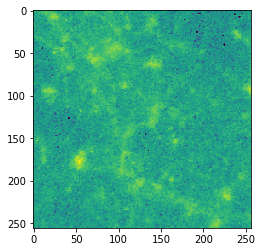

In [22]:
plt.imshow(data[0].squeeze())

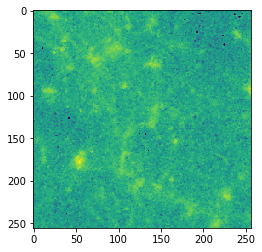

In [23]:
plt.imshow(adv_data[0].squeeze())

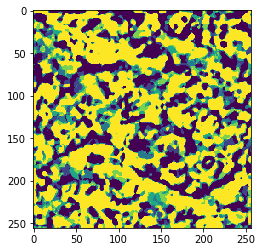

In [24]:
plt.imshow( (data-adv_data)[0].squeeze())